In [1]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from qick import *
from qick.pyro import make_proxy

from malab import SlabFile, get_next_filename
# for now, all the tProc v2 classes need to be individually imported (can't use qick.*)

# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSpan, QickSweep1D

import json
import datetime

from qualang_tools.plot import Fit

import pprint as pp

# Used for live plotting, need to run "python -m visdom.server" in the terminal and open the IP address in browser
import visdom

# from plotting_helpers import *

from build_task import *
from build_state import *

from expt_config import *
import system_config



No module named 'visa'
Warning VISA library import failed
Warning serial library import failed.
Could not load InstrumentManagerWindow
2024-10-10 12:52:49,258 - qm - INFO     - Starting session: 474ee731-fbcb-478c-b44c-59cdb92b8eb5


Connect to RFSoC using Pyro4

In [2]:
soc, soccfg = make_proxy(ns_host="192.168.1.144", ns_port=8000, proxy_name="rfsoc")
print(soccfg)

Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8000
rfsoc PYRO:obj_abcb24f3d6f84ba2a42bcaeab8773033@192.168.1.144:38541
QICK running on ZCU216, software version 0.2.289

Firmware configuration (built Fri Sep  6 11:13:08 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	12 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 32768 samples (4.762 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 32768 samples (4.762 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (4.762 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 32768 samples (4.762 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 3 i

# Time of flight

In [3]:
# ----- Experiment configurations ----- #
expt_name = "tof"
QubitIndex = QUBIT_INDEX
Qubit = 'Q' + str(QubitIndex)

exp_cfg = expt_cfg[expt_name]
q_config = all_qubit_state(system_config)
config = {**q_config['Q' + str(QubitIndex)], **exp_cfg}
print(config)

{'qubit_ch': 4, 'res_ch': 6, 'ro_ch': 1, 'trig_time': 0.65, 'ro_length': 10.0, 'res_freq': 7149.75, 'res_gain': 0.7, 'res_length': 1.0, 'res_phase': 0, 'threshold': 0, 'qubit_freq': 2964.29, 'qubit_gain': 0.41, 'qubit_length': 0.3, 'sigma': 0.2, 'reps': 1, 'soft_avgs': 1000, 'relax_delay': 1000}


In [ ]:
##################
# Define Program #
##################

class LoopbackProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        res_ch = cfg['res_ch']
        
        self.declare_gen(ch=res_ch, nqz=cfg['nqz_res'])
        # pynq configured
        # self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['freq'], gen_ch=gen_ch)
        
        # tproc configured
        self.declare_readout(ch=ro_ch, length=cfg['ro_length'])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['res_freq_ge'], gen_ch=res_ch)

        self.add_pulse(ch=res_ch, name="myconst", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['res_length'], 
                       freq=cfg['res_freq_ge'], 
                       phase=cfg['res_phase'],
                       gain=cfg['res_gain_ge'],
                      )
    
    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=cfg['res_ch'], name="myconst", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=0, ddr4=True)

config.update([('res_freq_ge', 7100), ('res_gain_ge', 0.8), ('res_length', 0.5), ('ro_length', 1.5)])

###################
# Run the Program
###################

prog =LoopbackProgram(soccfg, reps=1, final_delay=config['relax_delay'], cfg=config)
iq_list = prog.acquire_decimated(soc, soft_avgs=config['soft_avgs'])
t = prog.get_time_axis(ro_index=0)

In [ ]:
# Plot results.
plt.plot(t, iq_list[0][:,0], label="I value")
plt.plot(t, iq_list[0][:,1], label="Q value")
plt.plot(t, np.abs(iq_list[0].dot([1,1j])), label="magnitude")
plt.legend()
plt.ylabel("ADC Units")
plt.xlabel("us");
plt.title('Time of Flight Experiment')
######## SET THIS VALUE AS YOUR config['trig_time'] #########
plt.axvline(0.65, c='r') 

In [ ]:
#####################################
# ----- Saves data to a file ----- #
#####################################

prefix = str(datetime.date.today())
exp_name = expt_name + '_Q' + str(QubitIndex) + '_' + prefix
print('Experiment name: ' + exp_name)

data_path = "M:/malab\People\Santi\data\candle_qubit"

fname = get_next_filename(data_path, exp_name, suffix='.h5')
print('Current data file: ' + fname)

with SlabFile(data_path + '\\' + fname, 'a') as f:
    # 'a': read/write/create

    # - Adds data to the file - #
    f.append('t', t)

    f.append('avgi', iq_list[0].T[0])
    f.append('avgq', iq_list[0].T[1])

    f.attrs['config'] = json.dumps(config) # cant save configs yet with QickParams

data = data_path + '\\' + fname

# Resonator Spectroscopy ge

In [4]:
# ----- Experiment configurations ----- #
expt_name = "res_spec_ge"
QubitIndex = QUBIT_INDEX
Qubit = 'Q' + str(QubitIndex)

exp_cfg = add_qubit_experiment(expt_cfg, expt_name, QubitIndex)
q_config = all_qubit_state(system_config)
config = {**q_config['Q' + str(QubitIndex)], **exp_cfg}
print(config)

{'qubit_ch': 4, 'res_ch': 6, 'ro_ch': 1, 'trig_time': 0.65, 'ro_length': 10.0, 'res_freq': <qick.asm_v2.QickParam object at 0x000002C4EF263450>, 'res_gain': 0.7, 'res_length': 1.0, 'res_phase': 0, 'threshold': 0, 'qubit_freq': 2964.29, 'qubit_gain': 0.41, 'qubit_length': 0.3, 'sigma': 0.2, 'reps': 1000, 'py_avg': 10, 'start': 7147, 'stop': 7152, 'steps': 1000, 'relax_delay': 0.5}


In [5]:
## Using the Dynamically Configured Readout Channel ##
class SingleToneSpectroscopyProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        res_ch = cfg['res_ch']
        
        self.declare_gen(ch=res_ch, nqz=cfg['nqz_res'])
        self.declare_readout(ch=ro_ch, length=cfg['ro_length'])

        self.add_loop("freqloop", cfg["steps"])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['res_freq_ge'], gen_ch=res_ch)
        
        self.add_pulse(ch=res_ch, name="res_pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['res_length'], 
                       freq=cfg['res_freq_ge'], 
                       phase=cfg['res_phase'],
                       gain=cfg['res_gain_ge'],
                      )
        
    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=cfg['res_ch'], name="res_pulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

In [6]:
prog = SingleToneSpectroscopyProgram(soccfg, reps=config['reps'], final_delay=config['relax_delay'], cfg=config)
py_avg = config['py_avg']

# for live plotting
IS_VISDOM = True
if IS_VISDOM:
    expt_I = expt_Q = expt_mags = expt_phases = expt_pop = None
    viz = visdom.Visdom()
    assert viz.check_connection(timeout_seconds=5), "Visdom server not connected!"
    viz.close(win=None) # close previous plots
    win1 = viz.line( X=np.arange(0, 1), Y=np.arange(0, 1),
                    opts=dict(height=400, width=700, title='Resonator Spectroscopy', showlegend=True, xlabel='expt_pts'))

    for ii in range(py_avg):
        iq_list = prog.acquire(soc, soft_avgs=1, progress=False)
        freqs = prog.get_pulse_param("res_pulse", "freq", as_array=True)

        iq_list = iq_list[0][0].T
        # what is the correct shape/index?
        this_I = (iq_list[0])
        this_Q = (iq_list[1])

        if expt_I is None: # ii == 0
            expt_I, expt_Q = this_I, this_Q
        else:
            expt_I = (expt_I * ii + this_I) / (ii + 1.0)
            expt_Q = (expt_Q * ii + this_Q) / (ii + 1.0)

        expt_mags = np.abs(expt_I + 1j * expt_Q)  # magnitude
        expt_phases = np.angle(expt_I + 1j * expt_Q)  # phase

        viz.line(X = freqs, Y = expt_mags, win=win1, name='I',
                 opts=dict(height=400, width=700, title='Resonator Spectroscopy', showlegend=True, xlabel='expt_pts'))

    amps = np.abs(expt_I + 1j*expt_Q)
    
else:
    iq_list = prog.acquire(soc, soft_avgs = py_avg, progress=True)
    freqs = prog.get_pulse_param("res_pulse", "freq", as_array=True)
    amps = np.abs(iq_list[0][0].dot([1,1j]))

Setting up a new session...


In [ ]:
print("Fitting data...")
### Fit ###
fit = Fit()
# Choose the suitable fitting function
fit_result = fit.reflection_resonator_spectroscopy(freqs, amps)

fit_result = {
        "f": fit_result['f'],
        "kc": fit_result['kc'],
        "ki": fit_result['ki'],
        "k": fit_result['k'],
        "offset": fit_result['offset'],
        "slope": fit_result['slope']
    }

pp.pprint(fit_result)

# Plotting
plt.figure(figsize=(12,6))
plt.plot(freqs, amps, marker='o')
plt.ylabel("a.u.")
plt.xlabel("Resonator Frequency (MHz)")
plt.title('Resonator Spectroscopy')
# plt.xlim(7146, 7148)
plt.axvline(fit_result['f'][0], c='orange') # The frequency that you will put into config['f_res']

In [ ]:
#####################################
# ----- Saves data to a file ----- #
#####################################

prefix = str(datetime.date.today())
exp_name = expt_name + '_Q' + str(QubitIndex) + '_' + prefix
print('Experiment name: ' + exp_name)

data_path = "M:/malab\People\Santi\data\candle_qubit"

fname = get_next_filename(data_path, exp_name, suffix='.h5')
print('Current data file: ' + fname)

with SlabFile(data_path + '\\' + fname, 'a') as f:
    # 'a': read/write/create

    # - Adds data to the file - #
    f.append('fpts', freqs)
    f.append('amps', amps)
    if IS_VISDOM:
        f.append('avgi', expt_I)
        f.append('avgq', expt_Q)
    else:
        f.append('avgi', iq_list[0][0].T[0])
        f.append('avgq', iq_list[0][0].T[1])

    del config['res_freq'] # cant save QickParam
    # formats config into file as a single line
    f.attrs['config'] = json.dumps(config) # cant save configs yet with QickParams

    f.attrs['fit_result'] = json.dumps(fit_result)


data = data_path + '\\' + fname

# Qubit Spectroscopy ge

In [3]:
# ----- Experiment configurations ----- #
expt_name = "qubit_spec_ge"
QubitIndex = QUBIT_INDEX
Qubit = 'Q' + str(QubitIndex)

exp_cfg = add_qubit_experiment(expt_cfg, expt_name, QubitIndex)
q_config = all_qubit_state(system_config)
config = {**q_config['Q' + str(QubitIndex)], **exp_cfg}
print(config)

{'qubit_ch': 4, 'res_ch': 6, 'ro_ch': 1, 'trig_time': 0.65, 'ro_length': 10.0, 'res_freq_ge': 7149.75, 'res_gain_ge': 0.7, 'res_freq_ef': 7149.75, 'res_gain_ef': 0.7, 'res_length': 1.0, 'res_phase': 0, 'threshold': 0, 'qubit_freq_ge': <qick.asm_v2.QickParam object at 0x000001FF5037EC90>, 'qubit_gain_ge': 0.41, 'qubit_length_ge': 0.3, 'qubit_freq_ef': 2964.29, 'qubit_gain_ef': 0.41, 'qubit_length_ef': 0.3, 'sigma': 0.2, 'reps': 1000, 'py_avg': 10, 'start': 2920, 'stop': 3000, 'steps': 1000, 'relax_delay': 1000}


In [8]:
class PulseProbeSpectroscopyProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        res_ch = cfg['res_ch']
        qubit_ch = cfg['qubit_ch']
        
        self.declare_gen(ch=res_ch, nqz=cfg['nqz_res'])
        self.declare_gen(ch=qubit_ch, nqz=cfg['nqz_qubit'])
        self.declare_readout(ch=ro_ch, length=cfg['ro_length'])

        self.add_loop("freqloop", cfg["steps"])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['res_freq_ge'], gen_ch=res_ch)
        
        self.add_pulse(ch=res_ch, name="res_pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['res_length'], 
                       freq=cfg['res_freq_ge'], 
                       phase=cfg['res_phase'],
                       gain=cfg['res_gain_ge'],
                      )
        
        self.add_pulse(ch=qubit_ch, name="qubit_pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['qubit_length_ge'], 
                       freq=cfg['qubit_freq_ge'], 
                       phase= 0,
                       gain=cfg['qubit_gain_ge'],
                      )
    
    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=self.cfg["qubit_ch"], name="qubit_pulse", t=0)  #play probe pulse

        self.pulse(ch=cfg['res_ch'], name="res_pulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])


In [9]:
qspec=PulseProbeSpectroscopyProgram(soccfg, reps=1000, final_delay= 0.5, cfg=config)
py_avg = config['py_avg']

# for live plotting
IS_VISDOM = True
if IS_VISDOM:
    expt_I = expt_Q = expt_mags = expt_phases = expt_pop = None
    viz = visdom.Visdom()
    assert viz.check_connection(timeout_seconds=5), "Visdom server not connected!"
    viz.close(win=None) # close previous plots
    win1 = viz.line( X=np.arange(0, 1), Y=np.arange(0, 1),
        opts=dict(height=400, width=700, title='Qubit Spectroscopy', showlegend=True, xlabel='expt_pts'))

    for ii in range(py_avg):
        iq_list = qspec.acquire(soc, soft_avgs=1, progress=False)
        freqs = qspec.get_pulse_param('qubit_pulse', "freq", as_array=True)

        iq_list = iq_list[0][0].T
        # what is the correct shape/index?
        this_I = (iq_list[0])
        this_Q = (iq_list[1])

        if expt_I is None: # ii == 0
            expt_I, expt_Q = this_I, this_Q
        else:
            expt_I = (expt_I * ii + this_I) / (ii + 1.0)
            expt_Q = (expt_Q * ii + this_Q) / (ii + 1.0)

        expt_mags = np.abs(expt_I + 1j * expt_Q)  # magnitude
        expt_phases = np.angle(expt_I + 1j * expt_Q)  # phase

        viz.line(X = freqs, Y = expt_mags, win=win1, name='I')

    amps = np.abs(expt_I + 1j*expt_Q)
    
else:
    iq_list = qspec.acquire(soc, soft_avgs=py_avg, progress=True)
    freqs = qspec.get_pulse_param('qubit_pulse', "freq", as_array=True)
    amps = np.abs(iq_list[0][0].dot([1,1j]))

Setting up a new session...


{'f': [2963.1908615663974, 0.07405226259146845],
 'k': [13.671194466729688, 0.28431631676105584],
 'kc': [21.970605779366853, 0.0050424458436905415],
 'ki': [-8.299411312637165, 0.2792738709173653],
 'offset': [6.236386785291716, 0.00801244120908895]}


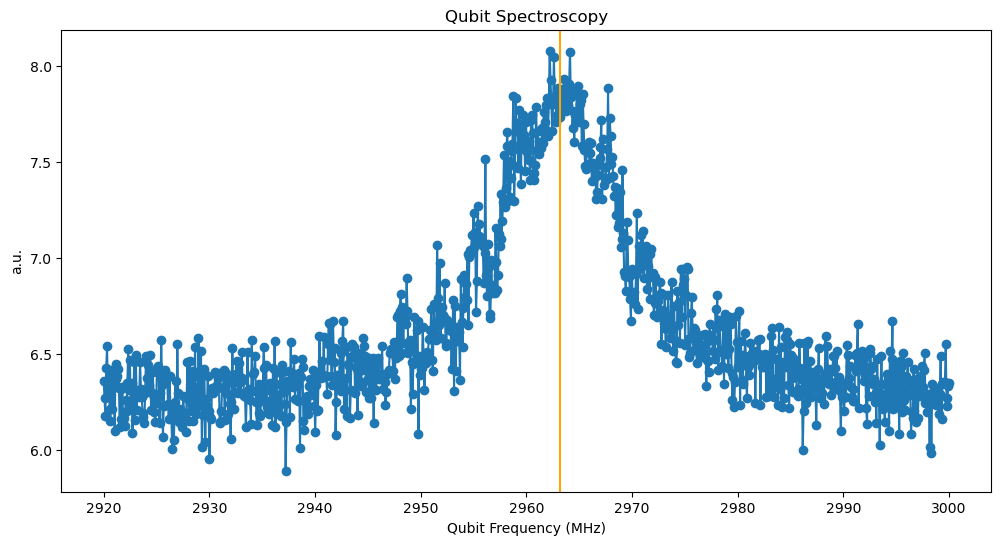

In [10]:
### Fit ###
fit = Fit()
# Choose the suitable fitting function
fit_result = fit.transmission_resonator_spectroscopy(freqs, amps)

# data = fit_result

fit_result = {
        "f": fit_result['f'],
        "kc": fit_result['kc'],
        "ki": fit_result['ki'],
        "k": fit_result['k'],
        "offset": fit_result['offset']
    }

pp.pprint(fit_result)

# plotting
plt.figure(figsize=(12,6))
plt.subplot(111,title="Qubit Spectroscopy", xlabel="Qubit Frequency (MHz)", ylabel="a.u.")
plt.plot(freqs, amps,'o-')
plt.axvline(fit_result['f'][0], c='orange'); # The qubit frequency that will be set in config['f_ge']

In [11]:
#####################################
# ----- Saves data to a file ----- #
#####################################

prefix = str(datetime.date.today())
exp_name = expt_name + '_Q' + str(QubitIndex) + '_' + prefix
print('Experiment name: ' + exp_name)

data_path = "M:/malab\People\Santi\data\candle_qubit"

fname = get_next_filename(data_path, exp_name, suffix='.h5')
print('Current data file: ' + fname)

with SlabFile(data_path + '\\' + fname, 'a') as f:
    # 'a': read/write/create

    # - Adds data to the file - #
    f.append('fpts', freqs)
    f.append('amps', amps)
    if IS_VISDOM:
        f.append('avgi', expt_I)
        f.append('avgq', expt_Q)
    else:
        f.append('avgi', iq_list[0][0].T[0])
        f.append('avgq', iq_list[0][0].T[1])

    del config['qubit_freq_ge']  # cant save QickParam
    # formats config into file as a single line
    f.attrs['config'] = json.dumps(config) # cant save configs yet with QickParams

    f.attrs['fit_result'] = json.dumps(fit_result)


data = data_path + '\\' + fname

Experiment name: qubit_spec_ge_Q0_2024-10-10
Current data file: 00000_qubit_spec_ge_Q0_2024-10-10.h5


# Length Rabi ge

In [3]:
# ----- Experiment configurations ----- #
expt_name = "time_rabi_ge"
QubitIndex = QUBIT_INDEX
Qubit = 'Q' + str(QubitIndex)

exp_cfg = add_qubit_experiment(expt_cfg, expt_name, QubitIndex)
q_config = all_qubit_state(system_config)
config = {**q_config['Q' + str(QubitIndex)], **exp_cfg}
print(config)

{'qubit_ch': 4, 'res_ch': 6, 'ro_ch': 1, 'trig_time': 0.65, 'ro_length': 10.0, 'res_freq_ge': 7149.75, 'res_gain_ge': 0.7, 'res_freq_ef': 7149.75, 'res_gain_ef': 0.7, 'res_length': 1.0, 'res_phase': 0, 'threshold': 0, 'qubit_freq_ge': 2964.29, 'qubit_gain_ge': 0.41, 'qubit_length_ge': 0.3, 'qubit_freq_ef': 2964.29, 'qubit_gain_ef': 0.41, 'qubit_length_ef': 0.3, 'qubit_phase': 0, 'sigma': 0.2, 'reps': 100, 'py_avg': 10, 'start': 0.02, 'expts': 50, 'step': 0.02, 'relax_delay': 1000}


In [4]:
class LengthRabiProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        res_ch = cfg['res_ch']
        qubit_ch = cfg['qubit_ch']
        
        self.declare_gen(ch=res_ch, nqz=cfg['nqz_res'])
        self.declare_gen(ch=qubit_ch, nqz=cfg['nqz_qubit'])
        # pynq configured
        # self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['f_res'], gen_ch=res_ch)
        
        # tproc configured
        self.declare_readout(ch=ro_ch, length=cfg['ro_length'])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['res_freq_ge'], gen_ch=res_ch)


        # self.add_loop("lenloop", cfg["steps"])
        
        self.add_pulse(ch=res_ch, name="res_pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['res_length'], 
                       freq=cfg['res_freq_ge'], 
                       phase=cfg['res_phase'],
                       gain=cfg['res_gain_ge'],
                      )
        
        self.add_pulse(ch=qubit_ch, name="qubit_pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['qubit_length_ge'], 
                       freq=cfg['qubit_freq_ge'], 
                       phase= cfg['qubit_phase'],
                       gain=cfg['qubit_gain_ge'],
                      )
        

    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=cfg["qubit_ch"], name="qubit_pulse", t=0)  #play probe pulse

        self.delay_auto(t=0.02, tag='waiting')
        
        self.pulse(ch=cfg['res_ch'], name="res_pulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])


In [7]:
expt_pts=[config["start"] + ii*config["step"] for ii in range(config["expts"])]

# for live plotting
IS_VISDOM = True
if IS_VISDOM:
    expt_I = expt_Q = expt_mags = expt_phases = expt_pop = None
    viz = visdom.Visdom()
    assert viz.check_connection(timeout_seconds=5), "Visdom server not connected!"
    viz.close(win=None) # close previous plots
    win1 = viz.line( X=np.arange(0, 1), Y=np.arange(0, 1),
        opts=dict(height=400, width=700, title='Length Rabi', showlegend=True, xlabel='expt_pts'))

py_avg = config['py_avg']
results_tot=[]
for ii in range(py_avg):
    results=[]
    wait_times=[]
    pulse_lengths=[]
    for length in expt_pts:
        config["qubit_length_ge"]=length

        rabi=LengthRabiProgram(soccfg,
                            reps=config['reps'],
                            final_delay=config['relax_delay'],
                            cfg=config)
        data = rabi.acquire(soc, soft_avgs = 1, progress=False)
        results.append(data[0][0])
        pulse_lengths.append(rabi.get_pulse_param('qubit_pulse', 'length', as_array=True))
        wait_times.append(rabi.get_time_param('waiting', 't', as_array=True))

    iq_list = np.array(results).T
    # what is the correct shape/index?
    this_I = (iq_list[0])
    this_Q = (iq_list[1])

    if expt_I is None: # ii == 0
        expt_I, expt_Q = this_I, this_Q
    else:
        expt_I = (expt_I * ii + this_I) / (ii + 1.0)
        expt_Q = (expt_Q * ii + this_Q) / (ii + 1.0)

    expt_mags = np.abs(expt_I + 1j * expt_Q)  # magnitude
    expt_phases = np.angle(expt_I + 1j * expt_Q)  # phase

    if IS_VISDOM:
        viz.line(X = pulse_lengths, Y = expt_mags, win=win1, name='I')

amps = expt_mags

Setting up a new session...


{'T': [85.3639032312868, 453.9081075235704],
 'amp': [5.403077662381119, 0.22098664043293578],
 'f': [2.01895468433806, 0.016675464794320125],
 'offset': [3.846173168027007, 0.09250627919512078],
 'phase': [3.115196948662909, 0.029568633459465733]}
Peak length: 0.24765290864561004 us


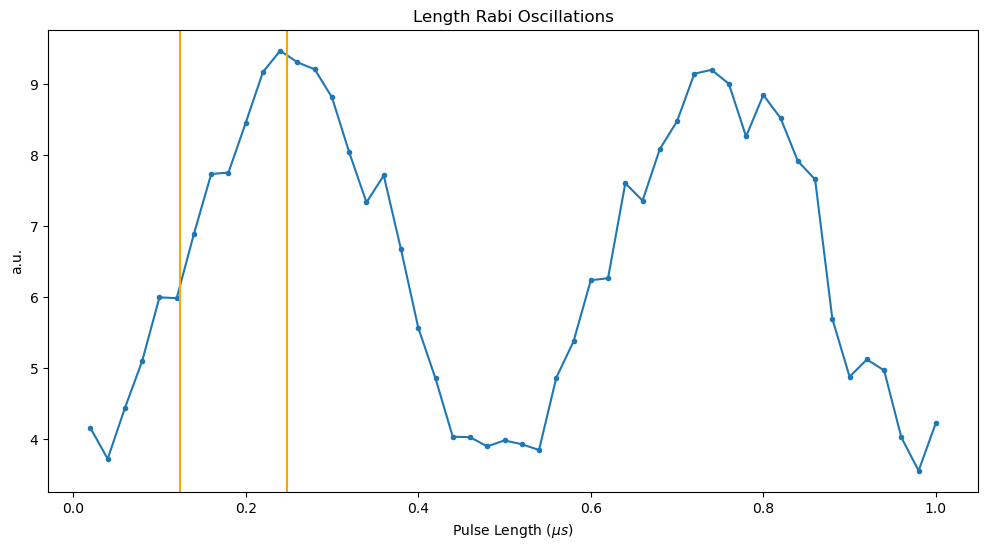

In [9]:
fit = Fit()
# Choose the suitable fitting function
fit_result = fit.rabi(expt_pts, amps)

fit_result = {
        "f": fit_result['f'],
        "phase": fit_result['phase'],
        "T": fit_result['T'],
        "amp": fit_result['amp'],
        "offset": fit_result['offset']
    }

pp.pprint(fit_result)

#plotting
plt.figure(figsize=(12,6))
plt.plot(expt_pts, amps, '.-')
plt.ylabel("a.u.")
plt.xlabel(r"Pulse Length ($\mu s$)")
plt.title(r'Length Rabi Oscillations')

peak = 0.5 / fit_result['f'][0]
plt.axvline(peak, c='orange') # pi_gain in config
plt.axvline(peak / 2, c='orange') # pi2_gain in config
print("Peak length:", peak, 'us')

In [10]:
#####################################
# ----- Saves data to a file ----- #
#####################################

prefix = str(datetime.date.today())
exp_name = expt_name + '_Q' + str(QubitIndex) + '_' + prefix
print('Experiment name: ' + exp_name)

data_path = "M:/malab\People\Santi\data\candle_qubit"

fname = get_next_filename(data_path, expt_name, suffix='.h5')
print('Current data file: ' + fname)

with SlabFile(data_path + '\\' + fname, 'a') as f:
    # 'a': read/write/create

    # - Adds data to the file - #
    f.append('lengths', expt_pts)
    f.append('amps', amps)
    if IS_VISDOM:
        f.append('avgi', expt_I)
        f.append('avgq', expt_Q)
    else:
        f.append('avgi', iq_list[0][0].T[0])
        f.append('avgq', iq_list[0][0].T[1])

    # formats config into file as a single line
    f.attrs['config'] = json.dumps(config)

data = data_path + '\\' + fname

Experiment name: time_rabi_ge_Q0_2024-10-10
Current data file: 00000_time_rabi_ge.h5


# Power Rabi ge

In [3]:
# ----- Experiment configurations ----- #
expt_name = "power_rabi_ge"
QubitIndex = QUBIT_INDEX
Qubit = 'Q' + str(QubitIndex)

exp_cfg = add_qubit_experiment(expt_cfg, expt_name, QubitIndex)
q_config = all_qubit_state(system_config)
config = {**q_config['Q' + str(QubitIndex)], **exp_cfg}
print(config)

{'qubit_ch': 4, 'res_ch': 6, 'ro_ch': 1, 'trig_time': 0.65, 'ro_length': 10.0, 'res_freq_ge': 7149.75, 'res_gain_ge': 0.7, 'res_freq_ef': 7149.75, 'res_gain_ef': 0.7, 'res_length': 1.0, 'res_phase': 0, 'threshold': 0, 'qubit_freq_ge': 2964.29, 'qubit_gain_ge': <qick.asm_v2.QickParam object at 0x0000018B5A5D2B10>, 'qubit_length_ge': 0.3, 'qubit_freq_ef': 2964.29, 'qubit_gain_ef': 0.41, 'qubit_length_ef': 0.3, 'qubit_phase': 0, 'sigma': 0.2, 'reps': 100, 'py_avg': 10, 'start': 0.0, 'stop': 1.0, 'steps': 200, 'relax_delay': 1000}


In [4]:
class AmplitudeRabiProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        res_ch = cfg['res_ch']
        qubit_ch = cfg['qubit_ch']
        
        self.declare_gen(ch=res_ch, nqz=cfg['nqz_res'])
        self.declare_gen(ch=qubit_ch, nqz=cfg['nqz_qubit'])
        # pynq configured
        # self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['f_res'], gen_ch=res_ch)
        
        # tproc configured
        self.declare_readout(ch=ro_ch, length=cfg['ro_length'])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['res_freq_ge'], gen_ch=res_ch)

        self.add_loop("gainloop", cfg["steps"])
        
        self.add_pulse(ch=res_ch, name="res_pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['res_length'], 
                       freq=cfg['res_freq_ge'], 
                       phase=cfg['res_phase'],
                       gain=cfg['res_gain_ge'],
                      )
        
        self.add_gauss(ch=qubit_ch, name="ramp", sigma=cfg['sigma'], length=cfg['sigma']*5, even_length=True)
        self.add_pulse(ch=qubit_ch, name="qubit_pulse", 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['qubit_freq_ge'], 
                       phase=cfg['qubit_phase'],
                       gain=cfg['qubit_gain_ge'], 
                      )
    
    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=cfg["qubit_ch"], name="qubit_pulse", t=0)  #play probe pulse
        
        self.delay_auto(t=0.01, tag='waiting')

        self.pulse(ch=cfg['res_ch'], name="res_pulse", t = 0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

        # relax delay ...


In [5]:
amp_rabi=AmplitudeRabiProgram(soccfg, reps=100, final_delay=config['relax_delay'], cfg=config)
py_avg = config['py_avg']

# for live plotting
IS_VISDOM = True
if IS_VISDOM:
    expt_I = expt_Q = expt_mags = expt_phases = expt_pop = None
    viz = visdom.Visdom()
    assert viz.check_connection(timeout_seconds=5), "Visdom server not connected!"
    viz.close(win=None) # close previous plots
    win1 = viz.line( X=np.arange(0, 1), Y=np.arange(0, 1),
        opts=dict(height=400, width=700, title='Power Rabi Experiment', showlegend=True, xlabel='expt_pts'))

    for ii in range(py_avg):
        iq_list = amp_rabi.acquire(soc, soft_avgs=1, progress=False)
        gains = amp_rabi.get_pulse_param('qubit_pulse', "gain", as_array=True)

        iq_list = iq_list[0][0].T
        # what is the correct shape/index?
        this_I = (iq_list[0])
        this_Q = (iq_list[1])

        if expt_I is None: # ii == 0
            expt_I, expt_Q = this_I, this_Q
        else:
            expt_I = (expt_I * ii + this_I) / (ii + 1.0)
            expt_Q = (expt_Q * ii + this_Q) / (ii + 1.0)

        expt_mags = np.abs(expt_I + 1j * expt_Q)  # magnitude
        expt_phases = np.angle(expt_I + 1j * expt_Q)  # phase

        viz.line(X = gains, Y = expt_mags, win=win1, name='I')

    amps = np.abs(expt_I + 1j*expt_Q)
    
else:
    iq_list = np.array(amp_rabi.acquire(soc, soft_avgs=py_avg, progress=True))
    gains = amp_rabi.get_pulse_param('qubit_pulse', "gain", as_array=True)
    amps = np.abs(iq_list[0][0].dot([1,1j]))

Setting up a new session...


{'T': [30.83490001938062, 183.62366915010114],
 'amp': [5.808235454295362, 0.45228909135720013],
 'f': [1.2333779803876928, 0.02017481486226029],
 'offset': [5.452947884031624, 0.07571002380057515],
 'phase': [6.235540626446696, 0.044232959793395685]}
Peak gain: 0.4053907301335418


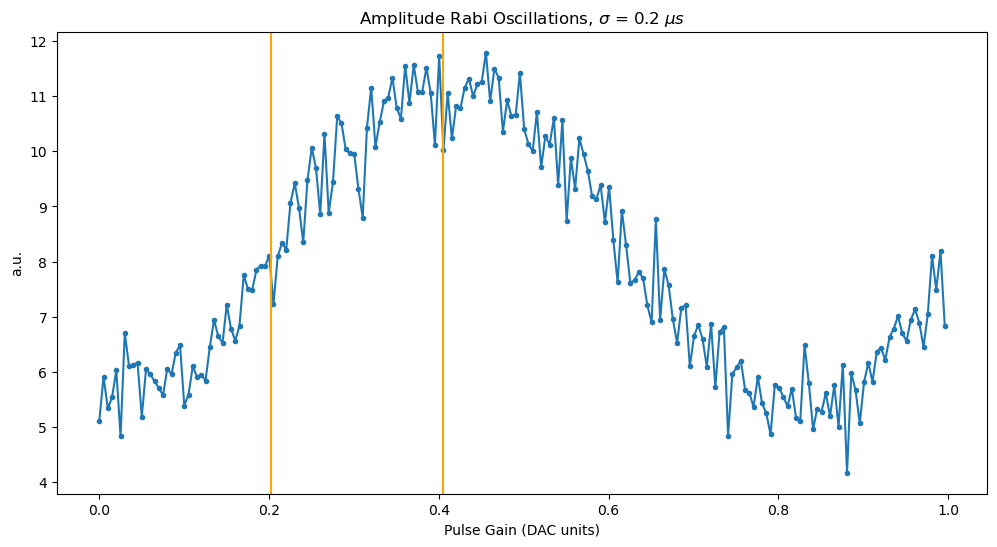

In [9]:
fit = Fit()
# Choose the suitable fitting function
fit_result = fit.rabi(gains, amps)

fit_result = {
        "f": fit_result['f'],
        "phase": fit_result['phase'],
        "T": fit_result['T'],
        "amp": fit_result['amp'],
        "offset": fit_result['offset']
    }

pp.pprint(fit_result)

#plotting
plt.figure(figsize=(12,6))
plt.plot(gains, amps, '.-')
plt.ylabel("a.u.")
plt.xlabel(r"Pulse Gain (DAC units)")
plt.title(r"Amplitude Rabi Oscillations, $\sigma$ = " + str(config['sigma']) + r' $\mu s$')

peak = 0.5 / fit_result['f'][0]
plt.axvline(peak, c='orange') # pi_gain in config
plt.axvline(peak / 2, c='orange') # pi2_gain in config
# plt.axvline(0.41, c='red')
print("Peak gain:", peak)

In [6]:
#####################################
    # ----- Saves data to a file ----- #
    #####################################

prefix = str(datetime.date.today())
exp_name = expt_name + '_Q' + str(QubitIndex) + '_' + prefix
print('Experiment name: ' + exp_name)

data_path = "M:/malab\People\Santi\data\candle_qubit"

fname = get_next_filename(data_path, expt_name, suffix='.h5')
print('Current data file: ' + fname)

with SlabFile(data_path + '\\' + fname, 'a') as f:
    # 'a': read/write/create

    # - Adds data to the file - #
    f.append('gains', gains)
    f.append('amps', amps)
    if IS_VISDOM:
        f.append('avgi', expt_I)
        f.append('avgq', expt_Q)
    else:
        f.append('avgi', iq_list[0][0].T[0])
        f.append('avgq', iq_list[0][0].T[1])

    del config['qubit_gain_ge']  # cant save QickParam
    # formats config into file as a single line
    f.attrs['config'] = json.dumps(config)

data = data_path + '\\' + fname

Experiment name: power_rabi_ge_Q0_2024-10-10
Current data file: 00000_power_rabi_ge.h5


# T2 Ramsey ge

In [3]:
# ----- Experiment configurations ----- #
expt_name = "Ramsey_ge"
QubitIndex = QUBIT_INDEX
Qubit = 'Q' + str(QubitIndex)

exp_cfg = add_qubit_experiment(expt_cfg, expt_name, QubitIndex)
q_config = all_qubit_state(system_config)
config = {**q_config['Q' + str(QubitIndex)], **exp_cfg}
print(config)

{'qubit_ch': 4, 'res_ch': 6, 'ro_ch': 1, 'trig_time': 0.65, 'ro_length': 10.0, 'res_freq_ge': 7149.75, 'res_gain_ge': 0.7, 'res_freq_ef': 7149.75, 'res_gain_ef': 0.7, 'res_length': 1.0, 'res_phase': 0, 'threshold': 0, 'qubit_freq_ge': 2964.29, 'qubit_gain_ge': 0.41, 'qubit_length_ge': 0.3, 'qubit_freq_ef': 2964.29, 'qubit_gain_ef': 0.41, 'qubit_length_ef': 0.3, 'qubit_phase': 0, 'sigma': 0.2, 'reps': 100, 'py_avg': 10, 'start': 0.0, 'stop': 100, 'steps': 100, 'ramsey_freq': 0.05, 'relax_delay': 1000, 'wait_time': <qick.asm_v2.QickParam object at 0x000001F3F3932250>}


In [4]:
class RamseyProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        res_ch = cfg['res_ch']
        qubit_ch = cfg['qubit_ch']
        
        self.declare_gen(ch=res_ch, nqz=cfg['nqz_res'])
        self.declare_gen(ch=qubit_ch, nqz=cfg['nqz_qubit'])
        # pynq configured
        # self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['f_res'], gen_ch=res_ch)
        
        # tproc configured
        self.declare_readout(ch=ro_ch, length=cfg['ro_length'])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['res_freq_ge'], gen_ch=res_ch)
        
        self.add_loop("waitloop", cfg["steps"])
        
        self.add_pulse(ch=res_ch, name="res_pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['res_length'], 
                       freq=cfg['res_freq_ge'], 
                       phase=cfg['res_phase'],
                       gain=cfg['res_gain_ge'],
                      )
        
        self.add_gauss(ch=qubit_ch, name="ramp", sigma=cfg['sigma'], length=cfg['sigma']*5, even_length=True)
        self.add_pulse(ch=qubit_ch, name="qubit_pulse1", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['qubit_freq_ge'], 
                       phase=cfg['qubit_phase'],
                       gain=cfg['qubit_gain_ge'] / 2, 
                      )
        
        self.add_pulse(ch=qubit_ch, name="qubit_pulse2", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['qubit_freq_ge'], 
                       phase=cfg['qubit_phase'] + cfg['wait_time']*360*cfg['ramsey_freq'], # current phase + time * 2pi * ramsey freq
                       gain=cfg['qubit_gain_ge'] / 2, 
                      )
    
    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=self.cfg["qubit_ch"], name="qubit_pulse1", t=0)  #play pulse
        
        self.delay_auto(cfg['wait_time']+0.01, tag='wait') # wait_time after last pulse
        
        self.pulse(ch=self.cfg["qubit_ch"], name="qubit_pulse2", t=0)  #play pulse

        self.delay_auto(0.01) # wait_time after last pulse
        
        self.pulse(ch=cfg['res_ch'], name="res_pulse", t=0) # play probe pulse
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

In [5]:
ramsey=RamseyProgram(soccfg, reps=100, final_delay=config['relax_delay'], cfg=config)
py_avg = 10

# for live plotting
IS_VISDOM = True
if IS_VISDOM:
    expt_I = expt_Q = expt_mags = expt_phases = expt_pop = None
    viz = visdom.Visdom()
    assert viz.check_connection(timeout_seconds=5), "Visdom server not connected!"
    viz.close(win=None) # close previous plots
    win1 = viz.line( X=np.arange(0, 1), Y=np.arange(0, 1),
        opts=dict(height=400, width=700, title='T2 Ramsey Experiment', showlegend=True, xlabel='expt_pts'))

    for ii in range(py_avg):
        iq_list = ramsey.acquire(soc, soft_avgs=1, progress=False)
        delay_times = ramsey.get_time_param('wait', "t", as_array=True)

        iq_list = iq_list[0][0].T
        # what is the correct shape/index?
        this_I = (iq_list[0])
        this_Q = (iq_list[1])

        if expt_I is None: # ii == 0
            expt_I, expt_Q = this_I, this_Q
        else:
            expt_I = (expt_I * ii + this_I) / (ii + 1.0)
            expt_Q = (expt_Q * ii + this_Q) / (ii + 1.0)

        expt_mags = np.abs(expt_I + 1j * expt_Q)  # magnitude
        expt_phases = np.angle(expt_I + 1j * expt_Q)  # phase

        viz.line(X = delay_times, Y = expt_mags, win=win1, name='I')

    amps = expt_mags
    
else:
    iq_list = ramsey.acquire(soc, soft_avgs=py_avg, progress=True)
    delay_times = ramsey.get_time_param('wait', "t", as_array=True)
    amps = np.abs(iq_list[0][0].dot([1,1j]))

Setting up a new session...


{'T2': [73.09137506687482, 8.347623467233653],
 'amp': [5.4456946969884426, 0.32862098821300356],
 'f': [0.03988614902702742, 0.000264820392527163],
 'final_offset': [6.849116137532132, 0.12059924918605101],
 'initial_offset': [5.94808419643981, 0.38362626928651505],
 'phase': [5.965481498223251, 0.0672490417538735]}


Text(0.5, 1.0, 'Ramsey Fringe Experiment')

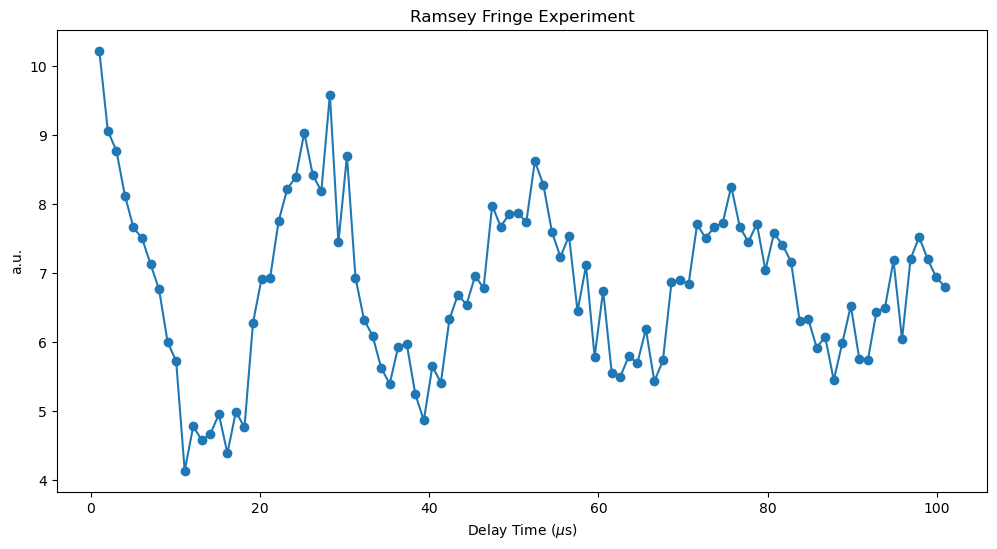

In [6]:
### Fit ###
fit = Fit()

# Choose the suitable fitting function
fit_result = fit.ramsey(delay_times, amps)

fit_result = {
    "f": fit_result['f'],
    "phase": fit_result['phase'],
    "T2": fit_result['T2'],
    "amp": fit_result['amp'],
    "initial_offset": fit_result['initial_offset'],
    "final_offset": fit_result['final_offset']
    }

pp.pprint(fit_result)

# plotting
plt.figure(figsize=(12,6))
plt.plot(delay_times, amps,'o-')
plt.ylabel("a.u.")
plt.xlabel(r"Delay Time ($\mu$s)")
plt.title(r"Ramsey Fringe Experiment")

In [7]:
#####################################
# ----- Saves data to a file ----- #
#####################################

prefix = str(datetime.date.today())
exp_name = expt_name + '_Q' + str(QubitIndex) + '_' + prefix
print('Experiment name: ' + exp_name)

data_path = "M:/malab\People\Santi\data\candle_qubit"

fname = get_next_filename(data_path, expt_name, suffix='.h5')
print('Current data file: ' + fname)

with SlabFile(data_path + '\\' + fname, 'a') as f:
    # 'a': read/write/create

    # - Adds data to the file - #
    f.append('delay_times', delay_times)
    f.append('amps', amps)
    if IS_VISDOM:
        f.append('avgi', expt_I)
        f.append('avgq', expt_Q)
    else:
        f.append('avgi', iq_list[0][0].T[0])
        f.append('avgq', iq_list[0][0].T[1])

    del config['wait_time']  # cant save QickParam
    # formats config into file as a single line
    f.attrs['config'] = json.dumps(config)

data = data_path + '\\' + fname

Experiment name: Ramsey_ge_Q0_2024-10-10
Current data file: 00000_Ramsey_ge.h5


# T2 Spin Echo ge

In [ ]:
# ----- Experiment configurations ----- #
expt_name = "SpinEcho_ge"
QubitIndex = QUBIT_INDEX
Qubit = 'Q' + str(QubitIndex)

exp_cfg = add_qubit_experiment(expt_cfg, expt_name, QubitIndex)
q_config = all_qubit_state(system_config)
config = {**q_config['Q' + str(QubitIndex)], **exp_cfg}
print(config)

In [ ]:

##################
# Define Program #
##################

class SpinEchoProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        res_ch = cfg['res_ch']
        qubit_ch = cfg['qubit_ch']
        
        self.declare_gen(ch=res_ch, nqz=cfg['nqz_res'])
        self.declare_gen(ch=qubit_ch, nqz=cfg['nqz_qubit'])
        # pynq configured
        # self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['f_res'], gen_ch=res_ch)
        
        # tproc configured
        self.declare_readout(ch=ro_ch, length=cfg['ro_length'])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['res_freq_ge'], gen_ch=res_ch)
        
        self.add_loop("waitloop", cfg["steps"])
        
        self.add_pulse(ch=res_ch, name="res_pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['res_length'], 
                       freq=cfg['res_freq_ge'], 
                       phase=cfg['res_phase'],
                       gain=cfg['res_gain_ge'],
                      )
        
        self.add_gauss(ch=qubit_ch, name="ramp", sigma=cfg['sigma'], length=cfg['sigma']*5, even_length=True)
        self.add_pulse(ch=qubit_ch, name="qubit_pulse1", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['qubit_freq_ge'], 
                       phase=cfg['qubit_phase'],
                       gain=cfg['qubit_gain_ge'] / 2, 
                      )
        
        # pi pulse
        self.add_pulse(ch=qubit_ch, name="qubit_pulse_pi", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['qubit_freq_ge'], 
                       phase=cfg['qubit_phase'],
                       gain=cfg['qubit_gain_ge'], 
                      )
        
        self.add_pulse(ch=qubit_ch, name="qubit_pulse2", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['qubit_freq_ge'], 
                       phase=cfg['qubit_phase'] + cfg['wait_time']*360*cfg['ramsey_freq'], # current phase + time * 2pi * ramsey freq
                       gain=cfg['qubit_gain_ge'] / 2, 
                      )
        
    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=self.cfg["qubit_ch"], name="qubit_pulse1", t=0)  #play pulse
        
        self.delay_auto((cfg['wait_time']/2)+0.01, tag = 'wait1') # wait_time after last pulse (wait / 2)
        
        self.pulse(ch=self.cfg["qubit_ch"], name="qubit_pulse_pi", t=0)  #play pulse
        
        self.delay_auto((cfg['wait_time']/2)+0.01, tag = 'wait2') # wait_time after last pulse (wait / 2)

        self.pulse(ch=self.cfg["qubit_ch"], name="qubit_pulse2", t=0)  #play pulse

        self.delay_auto(0.01) # wait_time after last pulse
        
        self.pulse(ch=cfg['res_ch'], name="res_pulse", t=0) # play probe pulse
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])


In [ ]:


###################
# Run the Program
###################

se=SpinEchoProgram(soccfg, reps=100, final_delay=config['relax_delay'], cfg=config)
py_avg = 10

# for live plotting
IS_VISDOM = True
if IS_VISDOM:
    expt_I = expt_Q = expt_mags = expt_phases = expt_pop = None
    viz = visdom.Visdom()
    assert viz.check_connection(timeout_seconds=5), "Visdom server not connected!"
    viz.close(win=None) # close previous plots
    win1 = viz.line( X=np.arange(0, 1), Y=np.arange(0, 1),
        opts=dict(height=400, width=700, title='T2 Spin Echo Experiment', showlegend=True, xlabel='expt_pts'))

    for ii in range(py_avg):
        iq_list = se.acquire(soc, soft_avgs=1, progress=False)
        delay_times1 = se.get_time_param('wait1', "t", as_array=True)
        delay_times2 = se.get_time_param('wait2', "t", as_array=True)

        iq_list = iq_list[0][0].T
        # what is the correct shape/index?
        this_I = (iq_list[0])
        this_Q = (iq_list[1])

        if expt_I is None: # ii == 0
            expt_I, expt_Q = this_I, this_Q
        else:
            expt_I = (expt_I * ii + this_I) / (ii + 1.0)
            expt_Q = (expt_Q * ii + this_Q) / (ii + 1.0)

        expt_mags = np.abs(expt_I + 1j * expt_Q)  # magnitude
        expt_phases = np.angle(expt_I + 1j * expt_Q)  # phase

        viz.line(X = delay_times1 + delay_times2, Y = expt_mags, win=win1, name='I')

    amps = expt_mags
    
else:
    iq_list = se.acquire(soc, soft_avgs=py_avg, progress=True)
    delay_times = se.get_time_param('wait', "t", as_array=True)
    amps = np.abs(iq_list[0][0].dot([1,1j]))

In [ ]:
### Fit ###
fit = Fit()

# Choose the suitable fitting function
fit_result = fit.se(delay_times1 + delay_times2, amps)

fit_result = {
    "f": fit_result['f'],
    "phase": fit_result['phase'],
    "T2": fit_result['T2'],
    "amp": fit_result['amp'],
    "initial_offset": fit_result['initial_offset'],
    "final_offset": fit_result['final_offset']
    }

pp.pprint(fit_result)

# plotting
plt.figure(figsize=(12,6))
plt.plot(delay_times1 + delay_times2, amps,'o-')
plt.ylabel("a.u.")
plt.xlabel(r"Delay Time ($\mu$s)")
plt.title(r"Spin Echo Experiment")

In [ ]:
#####################################
# ----- Saves data to a file ----- #
#####################################

prefix = str(datetime.date.today())
exp_name = expt_name + '_Q' + str(QubitIndex) + '_' + prefix
print('Experiment name: ' + exp_name)

data_path = "M:/malab\People\Santi\data\candle_qubit"

fname = get_next_filename(data_path, expt_name, suffix='.h5')
print('Current data file: ' + fname)

with SlabFile(data_path + '\\' + fname, 'a') as f:
    # 'a': read/write/create

    # - Adds data to the file - #
    f.append('delay_times1', delay_times1)
    f.append('delay_times2', delay_times2)
    f.append('amps', amps)
    if IS_VISDOM:
        f.append('avgi', expt_I)
        f.append('avgq', expt_Q)
    else:
        f.append('avgi', iq_list[0][0].T[0])
        f.append('avgq', iq_list[0][0].T[1])


    del config['wait_time']  # cant save QickParam
    # formats config into file as a single line
    f.attrs['config'] = json.dumps(config)

data = data_path + '\\' + fname

# T1 ge

In [3]:
# ----- Experiment configurations ----- #
expt_name = "T1_ge"
QubitIndex = QUBIT_INDEX
Qubit = 'Q' + str(QubitIndex)

exp_cfg = add_qubit_experiment(expt_cfg, expt_name, QubitIndex)
q_config = all_qubit_state(system_config)
config = {**q_config['Q' + str(QubitIndex)], **exp_cfg}
print(config)

{'qubit_ch': 4, 'res_ch': 6, 'ro_ch': 1, 'trig_time': 0.65, 'ro_length': 10.0, 'res_freq_ge': 7149.75, 'res_gain_ge': 0.7, 'res_freq_ef': 7149.75, 'res_gain_ef': 0.7, 'res_length': 1.0, 'res_phase': 0, 'threshold': 0, 'qubit_freq_ge': 2964.29, 'qubit_gain_ge': 0.41, 'qubit_length_ge': 0.3, 'qubit_freq_ef': 2964.29, 'qubit_gain_ef': 0.41, 'qubit_length_ef': 0.3, 'qubit_phase': 0, 'sigma': 0.2, 'reps': 100, 'py_avg': 10, 'start': 0.0, 'stop': 500.0, 'steps': 50, 'relax_delay': 1000, 'wait_time': <qick.asm_v2.QickParam object at 0x00000229E447E890>}


In [4]:
class T1Program(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        res_ch = cfg['res_ch']
        qubit_ch = cfg['qubit_ch']
        
        self.declare_gen(ch=res_ch, nqz=cfg['nqz_res'])
        self.declare_gen(ch=qubit_ch, nqz=cfg['nqz_qubit'])
        # pynq configured
        # self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['f_res'], gen_ch=res_ch)
        
        # tproc configured
        self.declare_readout(ch=ro_ch, length=cfg['ro_length'])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['res_freq_ge'], gen_ch=res_ch)


        self.add_loop("waitloop", cfg["steps"])
        
        self.add_pulse(ch=res_ch, name="res_pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['res_length'], 
                       freq=cfg['res_freq_ge'], 
                       phase=cfg['res_phase'],
                       gain=cfg['res_gain_ge'],
                      )
        
        self.add_gauss(ch=qubit_ch, name="ramp", sigma=cfg['sigma'], length=cfg['sigma']*5, even_length=True)
        self.add_pulse(ch=qubit_ch, name="qubit_pulse", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['qubit_freq_ge'], 
                       phase=cfg['qubit_phase'],
                       gain=cfg['qubit_gain_ge'], 
                      )
    
    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=self.cfg["qubit_ch"], name="qubit_pulse", t=0)  #play pulse
        
        self.delay_auto(cfg['wait_time']+0.01, tag='wait') # wait_time after last pulse

        self.pulse(ch=cfg['res_ch'], name="res_pulse", t=0) # play probe pulse
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

In [5]:
t1=T1Program(soccfg, reps=100, final_delay=config['relax_delay'], cfg=config)
py_avg = 10

# for live plotting
IS_VISDOM = True
if IS_VISDOM:
    expt_I = expt_Q = expt_mags = expt_phases = expt_pop = None
    viz = visdom.Visdom()
    assert viz.check_connection(timeout_seconds=5), "Visdom server not connected!"
    viz.close(win=None) # close previous plots
    win1 = viz.line( X=np.arange(0, 1), Y=np.arange(0, 1),
        opts=dict(height=400, width=700, title='T1 Experiment', showlegend=True, xlabel='expt_pts'))

    for ii in range(py_avg):
        iq_list = t1.acquire(soc, soft_avgs=1, progress=False)
        delay_times = t1.get_time_param('wait', "t", as_array=True)

        iq_list = iq_list[0][0].T
        # what is the correct shape/index?
        this_I = (iq_list[0])
        this_Q = (iq_list[1])

        if expt_I is None: # ii == 0
            expt_I, expt_Q = this_I, this_Q
        else:
            expt_I = (expt_I * ii + this_I) / (ii + 1.0)
            expt_Q = (expt_Q * ii + this_Q) / (ii + 1.0)

        expt_mags = np.abs(expt_I + 1j * expt_Q)  # magnitude
        expt_phases = np.angle(expt_I + 1j * expt_Q)  # phase

        viz.line(X = delay_times, Y = expt_mags, win=win1, name='I')

    amps = np.abs(expt_I + 1j*expt_Q)
    
else:
    iq_list = t1.acquire(soc, soft_avgs=py_avg, progress=True)
    delay_times = t1.get_time_param('wait', "t", as_array=True)
    amps = np.abs(iq_list[0][0].dot([1,1j]))

Setting up a new session...


{'T1': [72.37358375206577, 8.274944861286716],
 'amp': [4.519137778042712, 0.27149511362067785],
 'final_offset': [4.516245263813226, 0.08559128945995018]}


Text(0.5, 1.0, 'T1 Experiment')

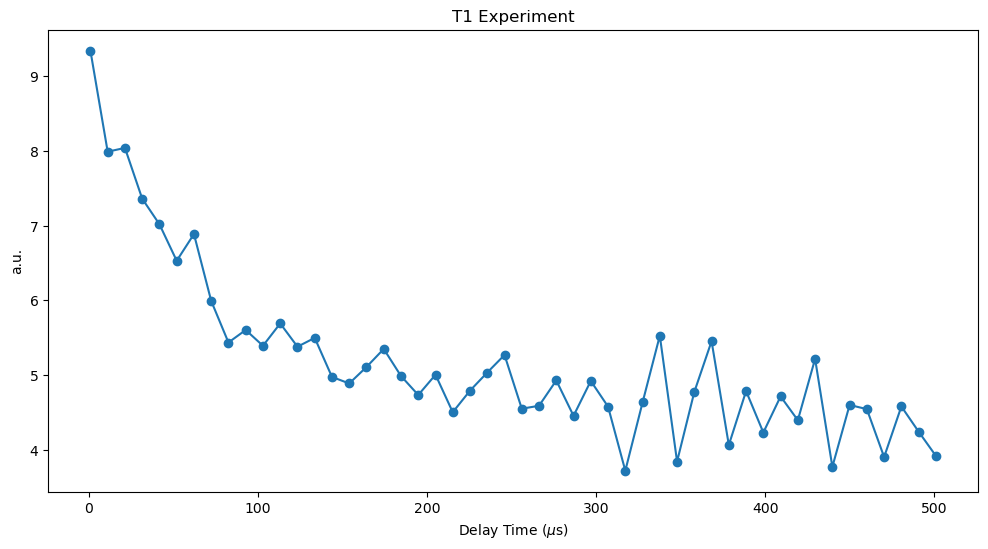

In [6]:
### Fit ###
fit = Fit()

# Choose the suitable fitting function
fit_result = fit.T1(delay_times, amps)

fit_result = {
        "T1": fit_result['T1'],
        "amp": fit_result['amp'],
        "final_offset": fit_result['final_offset']
    }

pp.pprint(fit_result)

# plotting
plt.figure(figsize=(12,6))
plt.plot(delay_times, amps,'o-')
plt.ylabel("a.u.")
plt.xlabel(r"Delay Time ($\mu$s)")
plt.title(r'T1 Experiment')


In [7]:
#####################################
# ----- Saves data to a file ----- #
#####################################

prefix = str(datetime.date.today())
exp_name = expt_name + '_Q' + str(QubitIndex) + '_' + prefix
print('Experiment name: ' + exp_name)

data_path = "M:/malab\People\Santi\data\candle_qubit"

fname = get_next_filename(data_path, expt_name, suffix='.h5')
print('Current data file: ' + fname)

with SlabFile(data_path + '\\' + fname, 'a') as f:
    # 'a': read/write/create

    # - Adds data to the file - #
    f.append('delay_times', delay_times)
    f.append('amps', amps)
    if IS_VISDOM:
        f.append('avgi', expt_I)
        f.append('avgq', expt_Q)
    else:
        f.append('avgi', iq_list[0][0].T[0])
        f.append('avgq', iq_list[0][0].T[1])

    del config['wait_time']  # cant save QickParam
    # formats config into file as a single line
    f.attrs['config'] = json.dumps(config)

data = data_path + '\\' + fname

Experiment name: T1_ge_Q0_2024-10-10
Current data file: 00000_T1_ge.h5


# Qubit Spec ef

In [ ]:
# ----- Experiment configurations ----- #
expt_name = "qubit_spec_ef"
QubitIndex = QUBIT_INDEX
Qubit = 'Q' + str(QubitIndex)

exp_cfg = add_qubit_experiment(expt_cfg, expt_name, QubitIndex)
q_config = all_qubit_state(system_config)
config = {**q_config['Q' + str(QubitIndex)], **exp_cfg}
print(config)

{'qubit_ch': 4, 'res_ch': 6, 'ro_ch': 1, 'trig_time': 0.65, 'ro_length': 10.0, 'res_freq_ge': 7149.75, 'res_gain_ge': 0.7, 'res_freq_ef': 7149.75, 'res_gain_ef': 0.7, 'res_length': 1.0, 'res_phase': 0, 'threshold': 0, 'qubit_freq_ge': <qick.asm_v2.QickParam object at 0x000001FF5037EC90>, 'qubit_gain_ge': 0.41, 'qubit_length_ge': 0.3, 'qubit_freq_ef': 2964.29, 'qubit_gain_ef': 0.41, 'qubit_length_ef': 0.3, 'sigma': 0.2, 'reps': 1000, 'py_avg': 10, 'start': 2920, 'stop': 3000, 'steps': 1000, 'relax_delay': 1000}


In [8]:
class PulseProbeSpectroscopyProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        res_ch = cfg['res_ch']
        qubit_ch = cfg['qubit_ch']
        
        self.declare_gen(ch=res_ch, nqz=cfg['nqz_res'])
        self.declare_gen(ch=qubit_ch, nqz=cfg['nqz_qubit'])
        self.declare_readout(ch=ro_ch, length=cfg['ro_length'])

        self.add_loop("freqloop", cfg["steps"])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['res_freq_ge'], gen_ch=res_ch)
        
        self.add_pulse(ch=res_ch, name="res_pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['res_length'], 
                       freq=cfg['res_freq_ge'], 
                       phase=cfg['res_phase'],
                       gain=cfg['res_gain_ge'],
                      )
        
        self.add_pulse(ch=qubit_ch, name="qubit_pulse_ge", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['qubit_length_ge'], 
                       freq=cfg['qubit_freq_ge'], 
                       phase= 0,
                       gain=cfg['qubit_gain_ge'],
                      )
        
        self.add_pulse(ch=qubit_ch, name="qubit_pulse_ef", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['qubit_length_ef'], 
                       freq=cfg['qubit_freq_ef'], 
                       phase= 0,
                       gain=cfg['qubit_gain_ef'],
                      )
    
    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=self.cfg["qubit_ch"], name="qubit_pulse_ge", t=0)  #play probe pulse
        self.delay_all(0.01)
        self.pulse(ch=self.cfg["qubit_ch"], name="qubit_pulse_ef", t=0)  #play probe pulse
        self.pulse(ch=cfg['res_ch'], name="res_pulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])


In [ ]:
qspec=PulseProbeSpectroscopyProgram(soccfg, reps=1000, final_delay= 0.5, cfg=config)
py_avg = config['py_avg']

# for live plotting
IS_VISDOM = True
if IS_VISDOM:
    expt_I = expt_Q = expt_mags = expt_phases = expt_pop = None
    viz = visdom.Visdom()
    assert viz.check_connection(timeout_seconds=5), "Visdom server not connected!"
    viz.close(win=None) # close previous plots
    win1 = viz.line( X=np.arange(0, 1), Y=np.arange(0, 1),
        opts=dict(height=400, width=700, title='Qubit Spectroscopy', showlegend=True, xlabel='expt_pts'))

    for ii in range(py_avg):
        iq_list = qspec.acquire(soc, soft_avgs=1, progress=False)
        freqs = qspec.get_pulse_param('qubit_pulse', "freq", as_array=True)

        iq_list = iq_list[0][0].T
        # what is the correct shape/index?
        this_I = (iq_list[0])
        this_Q = (iq_list[1])

        if expt_I is None: # ii == 0
            expt_I, expt_Q = this_I, this_Q
        else:
            expt_I = (expt_I * ii + this_I) / (ii + 1.0)
            expt_Q = (expt_Q * ii + this_Q) / (ii + 1.0)

        expt_mags = np.abs(expt_I + 1j * expt_Q)  # magnitude
        expt_phases = np.angle(expt_I + 1j * expt_Q)  # phase

        viz.line(X = freqs, Y = expt_mags, win=win1, name='I')

    amps = np.abs(expt_I + 1j*expt_Q)
    
else:
    iq_list = qspec.acquire(soc, soft_avgs=py_avg, progress=True)
    freqs = qspec.get_pulse_param('qubit_pulse', "freq", as_array=True)
    amps = np.abs(iq_list[0][0].dot([1,1j]))

Setting up a new session...


{'f': [2963.1908615663974, 0.07405226259146845],
 'k': [13.671194466729688, 0.28431631676105584],
 'kc': [21.970605779366853, 0.0050424458436905415],
 'ki': [-8.299411312637165, 0.2792738709173653],
 'offset': [6.236386785291716, 0.00801244120908895]}


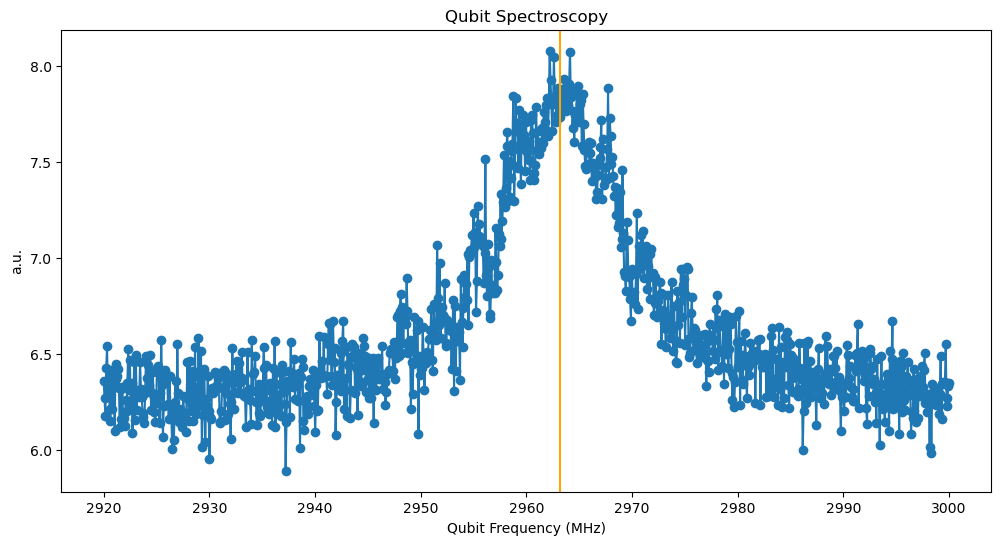

In [ ]:
### Fit ###
fit = Fit()
# Choose the suitable fitting function
fit_result = fit.transmission_resonator_spectroscopy(freqs, amps)

# data = fit_result

fit_result = {
        "f": fit_result['f'],
        "kc": fit_result['kc'],
        "ki": fit_result['ki'],
        "k": fit_result['k'],
        "offset": fit_result['offset']
    }

pp.pprint(fit_result)

# plotting
plt.figure(figsize=(12,6))
plt.subplot(111,title="Qubit Spectroscopy ef", xlabel="Qubit Frequency (MHz)", ylabel="a.u.")
plt.plot(freqs, amps,'o-')
plt.axvline(fit_result['f'][0], c='orange'); # The qubit frequency that will be set in config['f_ge']

In [ ]:
#####################################
# ----- Saves data to a file ----- #
#####################################

prefix = str(datetime.date.today())
exp_name = expt_name + '_Q' + str(QubitIndex) + '_' + prefix
print('Experiment name: ' + exp_name)

data_path = "M:/malab\People\Santi\data\candle_qubit"

fname = get_next_filename(data_path, exp_name, suffix='.h5')
print('Current data file: ' + fname)

with SlabFile(data_path + '\\' + fname, 'a') as f:
    # 'a': read/write/create

    # - Adds data to the file - #
    f.append('fpts', freqs)
    f.append('amps', amps)
    if IS_VISDOM:
        f.append('avgi', expt_I)
        f.append('avgq', expt_Q)
    else:
        f.append('avgi', iq_list[0][0].T[0])
        f.append('avgq', iq_list[0][0].T[1])

    del config['qubit_freq_ge']  # cant save QickParam
    # formats config into file as a single line
    f.attrs['config'] = json.dumps(config) # cant save configs yet with QickParams

    f.attrs['fit_result'] = json.dumps(fit_result)


data = data_path + '\\' + fname

Experiment name: qubit_spec_ge_Q0_2024-10-10
Current data file: 00000_qubit_spec_ge_Q0_2024-10-10.h5
